# Arrival Statistics

In [1]:
import xarray as xr
import bighorn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from kaooi.coordinates import depths
from tqdm import tqdm
import pandas as pd
import panel as pn
from matplotlib.lines import Line2D
import seaborn as sns
from dotenv import load_dotenv
import os

pn.extension()

# load .env file
env_path = '../.env'
_ = load_dotenv(env_path)

%config InlineBackend.figure_format='retina'

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
mls_integer = {
    'AXCC1':92,
    'AXEC2':92,
    'AXBA1':92,
    'LJ01C':98,
    'PC01A':97,
    'PC03A':92,
    'HYS14':98
}

fs_integer = {
    'AXCC1':252,
    'AXEC2':252,
    'AXBA1':252,
    'LJ01C':269,
    'PC01A':267,
    'PC03A':252,
    'HYS14':268
}


## Load observations

In [3]:
fn = f'{os.environ["data_directory"]}analysis/lf_stack.nc'
ds_lf = xr.open_dataset(fn)

fn = f'{os.environ["data_directory"]}analysis/bb_stack.nc'
ds_bb = xr.open_dataset(fn)

In [4]:
obs_time_bounds = {
    'AXCC1':slice(pd.Timestamp('2023-04-01'), pd.Timestamp('2023-05-01')),
    'AXEC2':slice(pd.Timestamp('2024-08-01'), pd.Timestamp('2024-09-01')),
    'AXBA1':slice(pd.Timestamp('2024-08-01'), pd.Timestamp('2024-09-01')),
    'HYS14':slice(pd.Timestamp('2024-10-01'), pd.Timestamp('2024-11-01')),
    'LJ01C':slice(pd.Timestamp('2024-02-01'), pd.Timestamp('2024-03-01')),
    'PC01A':slice(pd.Timestamp('2023-05-01'), pd.Timestamp('2023-06-01')),
    'PC03A':slice(pd.Timestamp('2023-05-01'), pd.Timestamp('2023-06-01')),
}

obs_time_bounds_bad = {
    'AXCC1':slice(pd.Timestamp('2024-01-25'), pd.Timestamp('2024-02-25')),
    'AXEC2':slice(pd.Timestamp('2024-01-25'), pd.Timestamp('2024-02-25')),
    'AXBA1':slice(pd.Timestamp('2024-01-25'), pd.Timestamp('2024-02-25')),
    'HYS14':slice(pd.Timestamp('2024-10-01'), pd.Timestamp('2024-11-01')),
    'LJ01C':slice(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-01')),
    'PC01A':slice(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-02-01')),
    'PC03A':slice(pd.Timestamp('2024-01-25'), pd.Timestamp('2024-02-25')),
}

noise_bounds = {
    'AXCC1':slice(17,27),
    'AXEC2':slice(17,27),
    'AXBA1':slice(17,27),
    'HYS14':slice(17,27),
    'LJ01C':slice(17,27),
    'PC01A':slice(5,15),
    'PC03A':slice(17,27),
}

In [5]:
rec_envs = {}
rec_envs_std = {}

for node in ['AXCC1', 'AXEC2', 'AXBA1', 'HYS14']:
    ds_slice = ds_lf[node].sel({'transmission':obs_time_bounds[node]})
    #ds_snr = ds_slice / ds_slice.sel({'shorttime':noise_bounds[node]}).std('shorttime')
    
    noise_rms = np.sqrt((ds_slice.sel({'shorttime':noise_bounds[node]})**2).mean('shorttime')) / np.sqrt(2)
    ds_snr = ds_slice / noise_rms
    
    rec_envs[node] = ds_snr.mean('transmission')
    rec_envs_std[node] = ds_snr.std('transmission')

    rec_envs[node] = rec_envs[node].assign_coords({'shorttime':rec_envs[node].shorttime + mls_integer[node]*27.28 + 27.28/2}).rename({'shorttime':'time'})
    rec_envs_std[node] = rec_envs_std[node].assign_coords({'shorttime':rec_envs_std[node].shorttime + mls_integer[node]*27.28 + 27.28/2}).rename({'shorttime':'time'})

for node in ['LJ01C', 'PC01A', 'PC03A']:
    ds_slice = ds_bb[node].sel({'transmission':obs_time_bounds[node]})
    #ds_snr = ds_slice / ds_slice.sel({'shorttime':noise_bounds[node]}).std('shorttime')
    
    noise_rms = np.sqrt((ds_slice.sel({'shorttime':noise_bounds[node]})**2).mean('shorttime')) / np.sqrt(2)
    ds_snr = ds_slice / noise_rms

    rec_envs[node] = ds_snr.mean('transmission')
    rec_envs_std[node] = ds_snr.std('transmission')

    rec_envs[node] = rec_envs[node].assign_coords({'shorttime':rec_envs[node].shorttime + mls_integer[node]*27.28 + 27.28/2}).rename({'shorttime':'time'})
    rec_envs_std[node] = rec_envs_std[node].assign_coords({'shorttime':rec_envs_std[node].shorttime + mls_integer[node]*27.28 + 27.28/2}).rename({'shorttime':'time'})

## Load simulation results

In [6]:
nodes = ['AXCC1','AXEC2','AXBA1','PC01A','PC03A', 'LJ01C', 'HYS14']
realizations = np.arange(1,51)

gfs = {}
means = {}
stds = {}
for node in nodes:
    gfs_single = []
    for realization in tqdm(realizations):
        fnr = f'{os.environ["data_directory"]}mc_iws/{node}_{realization:02}_Gfz_real.nc'
        fni = f'{os.environ["data_directory"]}mc_iws/{node}_{realization:02}_Gfz_imag.nc'
        
        gfs_single.append(xr.open_dataarray(fnr) + 1j * xr.open_dataarray(fni))
    gfs[node] = xr.concat(gfs_single, dim='realization')
    gts = bighorn.convert_to_time(gfs[node], 300, 10, (37.5, 112.5))
    means[node] = np.abs(gts.sel({'depth':depths[node]}, method='nearest')).mean('realization')
    means[node] = means[node].assign_coords({'time':means[node].time + fs_integer[node]*10})
    stds[node] = np.abs(gts.sel({'depth':depths[node]}, method='nearest')).std('realization')
    stds[node] = stds[node].assign_coords({'time':stds[node].time + fs_integer[node]*10})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.37it/s]


## Plot Results

In [7]:
20*np.log10(np.sqrt(2))

np.float64(3.0102999566398125)

In [8]:
xlims = {
    'AXCC1':(2523,2533),
    'AXEC2':(2523,2533),
    'AXBA1':(2528,2538),
    'PC01A':(2678,2688),
    'PC03A':(2529,2538),
    'LJ01C':(2695,2703),
}

ylims = {
    'AXCC1':(-4+3,9+3),
    'AXEC2':(-4+3,15+3),
    'AXBA1':(-4+3,8+3),
    'PC01A':(-4+3,9+3),
    'PC03A':(-4+3,11+3),
    'LJ01C':(-3+3,24+3)
}

sim_noise = {
    'AXCC1':152.5 + 3,
    'AXEC2':155 + 3,
    'AXBA1':161 + 3,
    'PC01A':152 + 3,
    'PC03A':155.5 + 3,
    'LJ01C':158.5 + 3
}

delta_t = {
    'AXCC1':1.33,
    'AXEC2':1.59,
    'AXBA1':1.69,
    'LJ01C':2.24,
    'PC01A':2.41,
    'PC03A':1.45,
}

In [9]:
def plot_node(node):
    
    single_mean = (20*np.log10(means[node])) + sim_noise[node]
    
    plt.plot(single_mean.time + delta_t[node], single_mean, lw=0.5, c='k', alpha=0.75)
    plt.plot(single_mean.time + 10 + delta_t[node], single_mean, lw=0.5, c='k', alpha=0.75)
    plt.fill_between(stds[node].time + delta_t[node], 20*np.log10(means[node] - stds[node]/2)+sim_noise[node], 20*np.log10(means[node] + stds[node]/2)+sim_noise[node], lw=0, alpha=0.3, color='k')
    plt.fill_between(stds[node].time + 10 + delta_t[node], 20*np.log10(means[node] - stds[node]/2)+sim_noise[node], 20*np.log10(means[node] + stds[node]/2)+sim_noise[node], lw=0, alpha=0.3, color='k')

    plt.title('')
    
    (20*np.log10(rec_envs[node]) ).plot(c=color_red, alpha=0.75, lw=0.5)
    (20*np.log10(rec_envs[node].assign_coords({'time':rec_envs[node]['time']-27.28}))).plot(c=color_red, alpha=0.75, lw=0.5)
    (20*np.log10(rec_envs[node].assign_coords({'time':rec_envs[node]['time']+27.28}))).plot(c=color_red, alpha=0.75, lw=0.5)
     
    plt.fill_between(
        rec_envs[node].time,
        20*np.log10(rec_envs[node] - rec_envs_std[node]/2) ,
        20*np.log10(rec_envs[node] + rec_envs_std[node]/2),
        lw=0,
        alpha=0.2,
        color=color_red
    )
    plt.fill_between(
        rec_envs[node].time-27.28,
        20*np.log10(rec_envs[node] - rec_envs_std[node]/2) ,
        20*np.log10(rec_envs[node] + rec_envs_std[node]/2),
        lw=0,
        alpha=0.2,
        color=color_red
    )
    plt.fill_between(
        rec_envs[node].time+27.28,
        20*np.log10(rec_envs[node] - rec_envs_std[node]/2) ,
        20*np.log10(rec_envs[node] + rec_envs_std[node]/2),
        lw=0,
        alpha=0.2,
        color=color_red
    )

    plt.xlim(xlims[node])
    plt.ylim(ylims[node])

    plt.ylabel('SNR [dB]', labelpad=-1)
    plt.xlabel('time [s]')

def plot_inset(node, ax, xlims, ylims):
    plot_node(node)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('')
    plt.ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', direction='in', length=2.2, width=0.75)
    ax.tick_params(axis='x', direction='in', length=2.2, width=0.75)

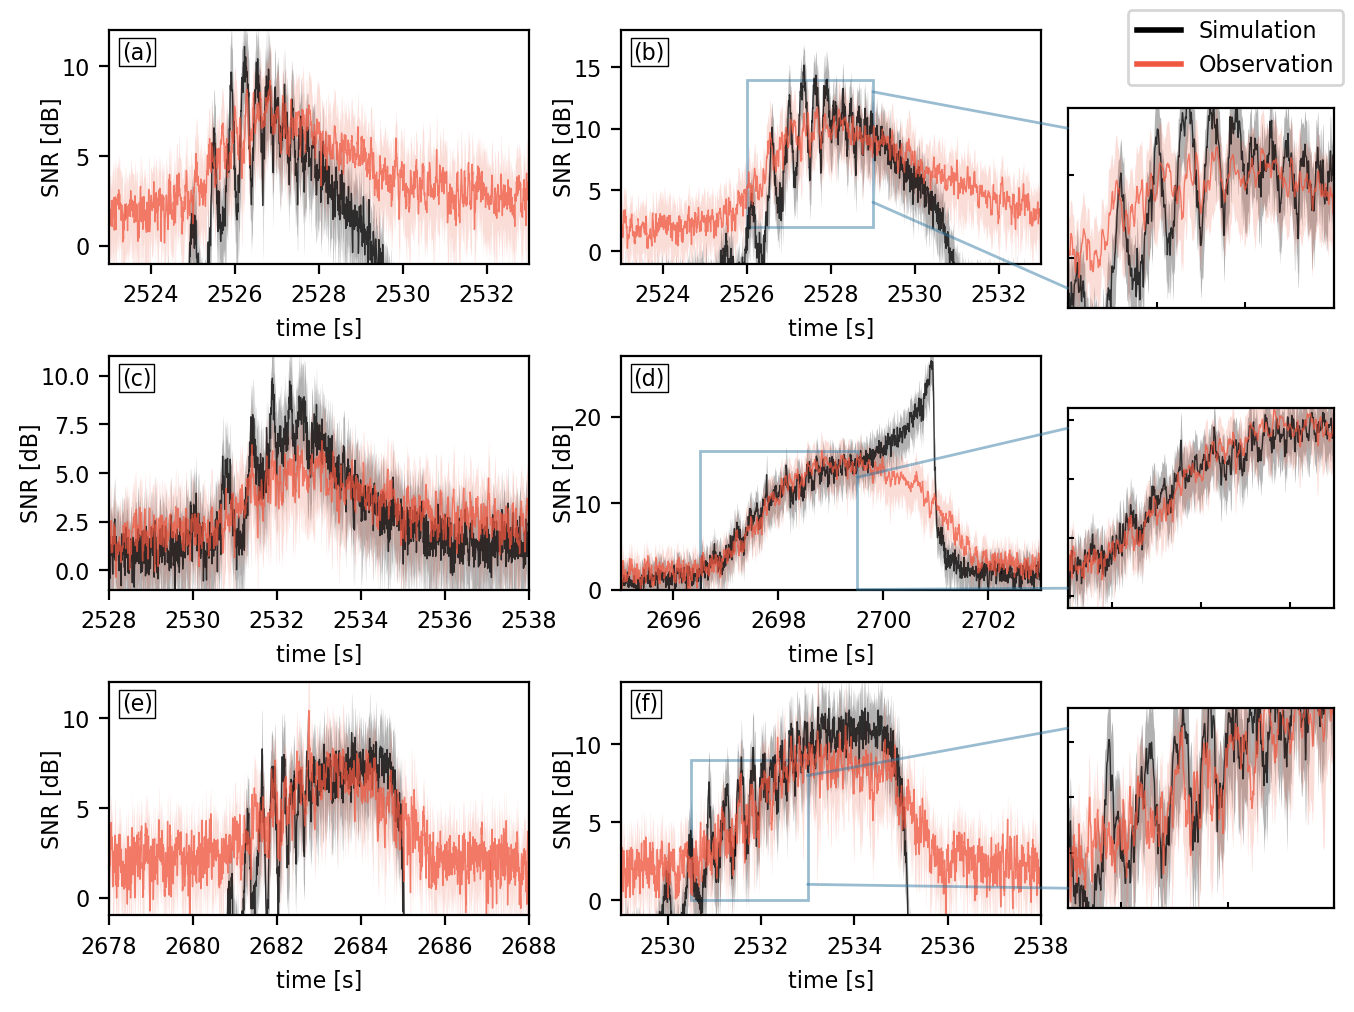

In [10]:
nodes_plot = ['AXCC1','AXEC2','AXBA1','LJ01C','PC01A','PC03A']

color_red = sns.color_palette("rocket", as_cmap=True)(0.65)
color_blue = sns.color_palette("mako", as_cmap=True)(0.5)

plt.rcParams.update({'font.size':8})
fig,axes = plt.subplots(3,2,figsize=(6.67,5))
axes = axes.flatten()

letters = ['(a)','(b)','(c)','(d)','(e)','(f)']

# add letters
for k, ax in enumerate(axes):
    ax.text(
        0.03,
        0.88,
        letters[k],
        transform=ax.transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=1, linewidth=0.5)
    )
    
for k, node in enumerate(nodes_plot):
    plt.sca(axes[k])
    plot_node(node)

plt.tight_layout(pad=1)
fig.subplots_adjust(right=0.78)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color=color_red, lw=2),]
fig.legend(custom_lines, ['Simulation','Observation'], loc='upper right')

# Add insets
ax_ac_inset = fig.add_axes((0.8, 0.7, 0.2, 0.2))
plt.sca(ax_ac_inset)
plot_inset('AXEC2', ax_ac_inset, (2526,2529), (2,14))
ac_inset_patch = matplotlib.patches.Rectangle((2526,2), 3, 12, facecolor='none', edgecolor=color_blue, linestyle='-', linewidth=1, alpha=0.5)
axes[1].add_patch(ac_inset_patch)

ax_lj01c_inset = fig.add_axes((0.8, 0.4, 0.2, 0.2))
plt.sca(ax_lj01c_inset)
plot_inset('LJ01C', ax_lj01c_inset, (2696.5, 2699.5), (-1,16))
ac_inset_patch2 = matplotlib.patches.Rectangle((2696.5,-1), 3, 17, facecolor='none', edgecolor=color_blue, linestyle='-', linewidth=1, alpha=0.5)
axes[3].add_patch(ac_inset_patch2)

ax_pc03a_inset = fig.add_axes((0.8, 0.1, 0.2, 0.2))
plt.sca(ax_pc03a_inset)
plot_inset('PC03A', ax_pc03a_inset, (2530.5, 2533), (0,9))
ac_inset_patch3 = matplotlib.patches.Rectangle((2530.5,0), 2.5, 9, facecolor='none', edgecolor=color_blue, linestyle='-', linewidth=1, alpha=0.5)
_ = axes[5].add_patch(ac_inset_patch3)


# Add Inset Connections
# Connect AXEC2 inset (top)
con1 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.1),  # coordinates in inset axes (left middle)
    xyB=(2529,4),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_ac_inset,
    axesB=axes[1],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)


con2 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.9),  # coordinates in inset axes (left middle)
    xyB=(2529,13),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_ac_inset,
    axesB=axes[1],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)

con3 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.1),  # coordinates in inset axes (left middle)
    xyB=(2699.5,0),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_lj01c_inset,
    axesB=axes[3],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)
con4 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.9),  # coordinates in inset axes (left middle)
    xyB=(2699.5,13),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_lj01c_inset,
    axesB=axes[3],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)

con5 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.1),  # coordinates in inset axes (left middle)
    xyB=(2533,1),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_pc03a_inset,
    axesB=axes[5],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)
con6 = matplotlib.patches.ConnectionPatch(
    xyA=(0, 0.9),  # coordinates in inset axes (left middle)
    xyB=(2533,8),   # coordinates in main axes (right side of rectangle)
    coordsA="axes fraction",
    coordsB="data",
    axesA=ax_pc03a_inset,
    axesB=axes[5],
    color=color_blue,
    linestyle='-',
    linewidth=1,
    alpha=0.5
)

fig.add_artist(con1)
fig.add_artist(con2)
fig.add_artist(con3)
fig.add_artist(con4)
fig.add_artist(con5)
fig.add_artist(con6)

#fig.patch.set_edgecolor('blue')
#fig.patch.set_linewidth(2)
fig.savefig('figures/ArrivalStats.pdf', bbox_inches='tight')

## Presentation Figures

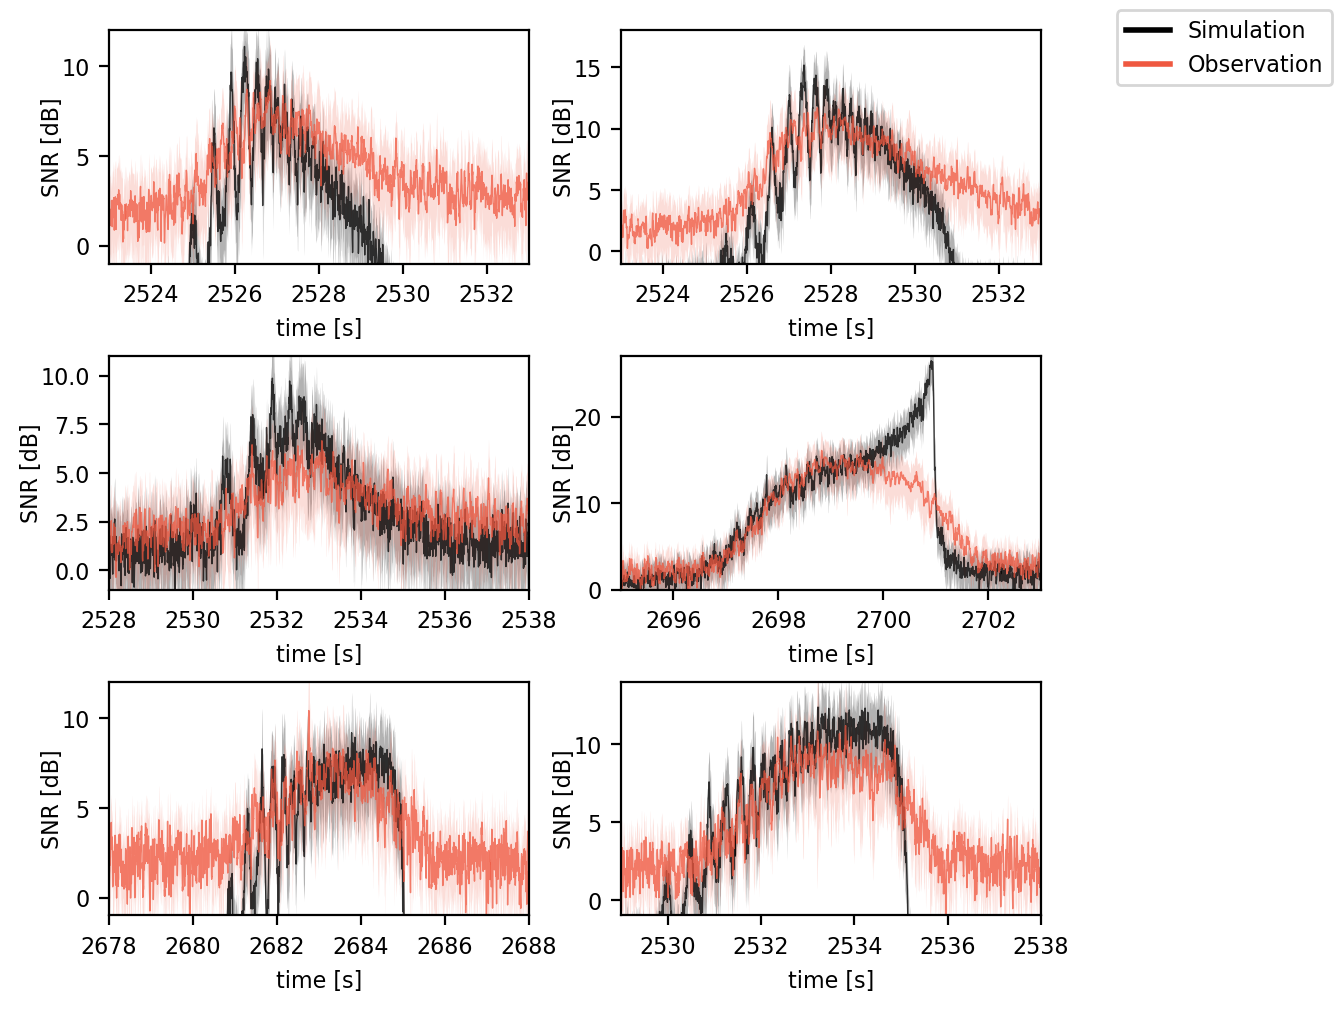

In [11]:
nodes_plot = ['AXCC1','AXEC2','AXBA1','LJ01C','PC01A','PC03A']

color_red = sns.color_palette("rocket", as_cmap=True)(0.65)
color_blue = sns.color_palette("mako", as_cmap=True)(0.5)

plt.rcParams.update({'font.size':8})
fig,axes = plt.subplots(3,2,figsize=(6.67,5))
axes = axes.flatten()

letters = ['(a)','(b)','(c)','(d)','(e)','(f)']
    
for k, node in enumerate(nodes_plot):
    plt.sca(axes[k])
    plot_node(node)

plt.tight_layout(pad=1)
fig.subplots_adjust(right=0.78)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color=color_red, lw=2),]
fig.legend(custom_lines, ['Simulation','Observation'], loc='upper right')


#fig.patch.set_edgecolor('blue')
#fig.patch.set_linewidth(2)
fig.savefig('figures/ArrivalStats_presentation.png', bbox_inches='tight', dpi=500)

## Calculate SNR $\epsilon$ for model

In [17]:
SL = 187
alpha = 8.075e-4
PG = 43.2


med_noise_level = { #dB rel uPa2/Hz
    'AXCC1':57.55,
    'AXEC2':58.89,
    'AXBA1':55.8,
    'PC01A':79.91,
    'PC03A':76.67,
    'LJ01C':72.16,
}

distance = { # km
    'AXCC1':3739.3,
    'AXEC2':3740.6,
    'AXBA1':3748.4,
    'PC01A':3970.0,
    'PC03A':3748.4,
    'LJ01C':3993.8,
}

total_offset = {}
epsilon = {}

for node in ['AXCC1','AXEC2','AXBA1','PC01A','PC03A','LJ01C']:
    total_offset[node] = SL - alpha * distance[node] - med_noise_level[node] +  PG
    epsilon[node] = sim_noise[node] - total_offset[node]

In [18]:
epsilon

{'AXCC1': -14.130515250000002,
 'AXEC2': -10.289465500000006,
 'AXBA1': -7.373166999999967,
 'PC01A': 7.9157749999999965,
 'PC03A': 7.996833000000009,
 'LJ01C': 6.684993500000019}

### panel app to get allignment

In [42]:
def plot_arrivals(node, dt, noise_power):

    fig = plt.figure()
    plt.plot(means[node].time + dt, 20*np.log10(means[node]) + noise_power, c='C0')
    plt.plot(means[node].time + dt+10, 20*np.log10(means[node]) + noise_power, c='C0')
    (20*np.log10(rec_envs[node])).plot(c='C1')
    
    plt.ylim([3,20])
    plt.xlim([2525, 2540])
    plt.title(f'{node}: dt={dt}, noise={noise_power}')
    plt.close()
    return fig

In [43]:
time_slider = pn.widgets.FloatSlider(name='Time Offset [s]', start=-4, end=4, step=0.01, value=0)
noise_slider = pn.widgets.FloatSlider(name='Noise Power [dB rel uPa2]', start=150, end=170, step=0.5, value=165)
plot_pane = pn.bind(plot_arrivals, 'PC03A', time_slider, noise_slider)

Column
    [0] FloatSlider(end=4, name='Time Offset [s]', start=-4, step=0.01)
    [1] FloatSlider(end=170, name='Noise Power [..., start=150, step=0.5, value=165)
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
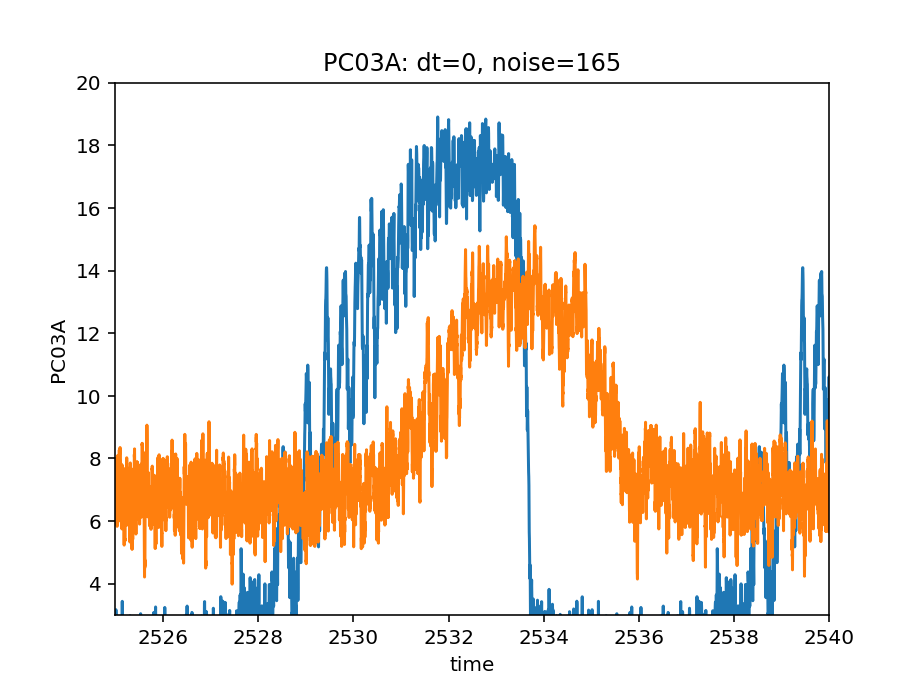

In [44]:
pn.Column(time_slider, noise_slider, plot_pane)